In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 

# Understanding Relations

![RelationalImage](relation_image.png)

# Time EDA

In [2]:
td = pd.read_csv('data/time_dim.csv')
td['date'] = td['date'].apply(lambda x : pd.to_datetime(x, format='%d-%m-%Y %H:%M'))
ft = pd.read_csv('data/fact_table.csv')

In [3]:
ft['customer_key'] = ft['coustomer_key']
ft = ft.drop(columns = ['coustomer_key'])

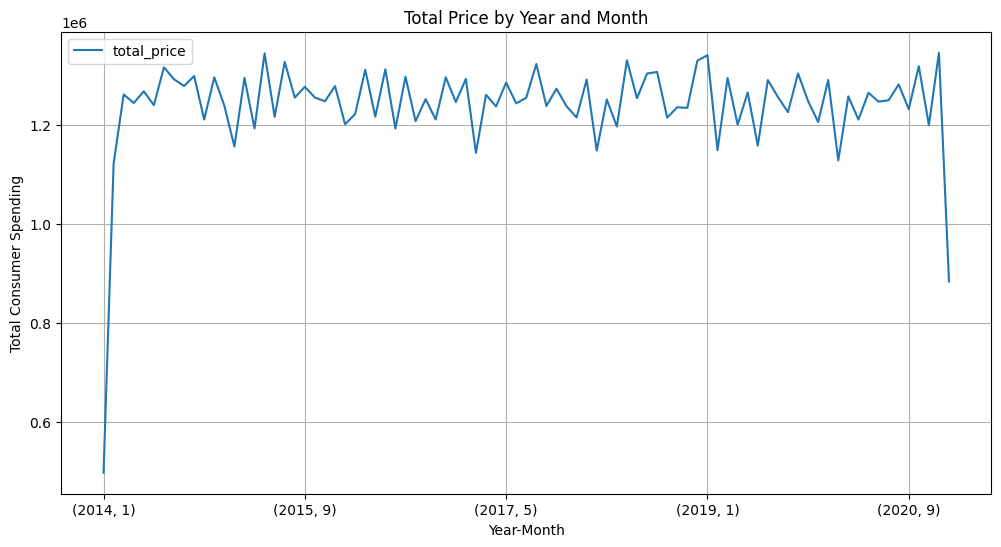

In [4]:
## Let's start with trends in total price per year month
time_fact = ft.merge(td, how = 'inner', left_on= 'time_key', right_on = 'time_key')
trends = time_fact[['year','quarter','month','total_price']].groupby(['year','month'])[['total_price']].sum()
trends.plot(figsize=(12, 6), title='Total Price by Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Consumer Spending')
plt.grid(True)
plt.show()


https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/

In [5]:
## RFM MODEL recency, frequency, and monetary value

rfm_model = (
    time_fact  
    .groupby('customer_key')  
    .agg(
        cust_id=('customer_key', 'first'), 
        purchase_times=('customer_key', 'size'), 
        total_amount=('total_price', 'sum'), 
        recent_sale_date=('date', 'max'),  
        start_sale_date=('date', 'min')  
    )
    .reset_index()  
)

rfm_model['cust_age'] = (rfm_model['recent_sale_date'] - rfm_model['start_sale_date']).dt.days
reference_date = pd.to_datetime('2021-02-01')
rfm_model['day_since_last_visit'] = (reference_date - rfm_model['recent_sale_date']).dt.days
rfm_model.head()

,customer_key,cust_id,purchase_times,total_amount,recent_sale_date,start_sale_date,cust_age,day_since_last_visit
0,C000001,C000001,82,8344.75,2021-01-12 11:41:00,2014-02-06 04:56:00,2532,19
1,C000002,C000002,103,11025.50,2020-11-22 17:48:00,2014-02-28 22:21:00,2458,70
2,C000003,C000003,108,12120.25,2020-11-02 22:31:00,2014-01-24 01:22:00,2474,90
3,C000004,C000004,118,13337.00,2020-12-21 16:50:00,2014-02-14 00:32:00,2502,41
4,C000005,C000005,108,10893.25,2020-11-23 07:07:00,2014-01-22 02:57:00,2497,69


In [6]:
scorerfm_agg = rfm_model.copy()

scorerfm_agg['r_score'] = pd.qcut(scorerfm_agg['day_since_last_visit'], q=5, labels=False, duplicates='drop') + 1
scorerfm_agg['f_score'] = pd.qcut(scorerfm_agg['purchase_times'], q=5, labels=False, duplicates='drop') + 1
scorerfm_agg['m_score'] = pd.qcut(scorerfm_agg['total_amount'], q=5, labels=False, duplicates='drop') + 1

scorerfm_agg.head()

,customer_key,cust_id,purchase_times,total_amount,recent_sale_date,start_sale_date,cust_age,day_since_last_visit,r_score,f_score,m_score
0,C000001,C000001,82,8344.75,2021-01-12 11:41:00,2014-02-06 04:56:00,2532,19,2,1,1
1,C000002,C000002,103,11025.50,2020-11-22 17:48:00,2014-02-28 22:21:00,2458,70,5,2,2
2,C000003,C000003,108,12120.25,2020-11-02 22:31:00,2014-01-24 01:22:00,2474,90,5,3,4
3,C000004,C000004,118,13337.00,2020-12-21 16:50:00,2014-02-14 00:32:00,2502,41,4,4,5
4,C000005,C000005,108,10893.25,2020-11-23 07:07:00,2014-01-22 02:57:00,2497,69,5,3,2


In [7]:
scorerfm_agg['avg_score'] = (scorerfm_agg['f_score'] + scorerfm_agg['m_score']) / 2
scorerfm_agg['status'] = pd.cut(scorerfm_agg['avg_score'], bins=[0, 3, float('inf')], labels=['Low', 'High'], right=False)
def calc_rfm(row): 
      if row['r_score'] >= 3 and row['status'] == 'High':
            return 'Hooked' 
      elif row['r_score'] >= 3 and row['status'] == 'Low':
            return 'Potential_customer'
      elif row['r_score'] < 3 and row['status'] == 'High':
            return 'Can\'t_loose' 
      elif row['r_score'] < 3 and row['status'] == 'Low':
            return 'Lost'
      else: 
            return 'Error'

scorerfm_agg['status'] = scorerfm_agg.apply(calc_rfm, axis=1)
scorerfm_agg[['customer_key', 'cust_age', 'r_score', 'f_score', 'm_score', 'status']]

,customer_key,cust_age,r_score,f_score,m_score,status
0,C000001,2532,2,1,1,Lost
1,C000002,2458,5,2,2,Potential_customer
2,C000003,2474,5,3,4,Hooked
3,C000004,2502,4,4,5,Hooked
4,C000005,2497,5,3,2,Potential_customer
...,...,...,...,...,...,...
9186,C009187,2529,4,3,4,Hooked
9187,C009188,2512,4,4,5,Hooked
9188,C009189,2555,1,4,3,Can't_loose
9189,C009190,2499,5,5,5,Hooked


In [8]:
time_fact.sort_values(by=['customer_key', 'date'], inplace=True)

time_fact['last_time_visit'] = time_fact.groupby('customer_key')['date'].shift(1)
time_fact['day_between_visit'] = (time_fact['date'] - time_fact['last_time_visit']).dt.days

filtered_df = time_fact.dropna(subset=['last_time_visit'])

avg_day_visit = filtered_df.groupby('customer_key')['day_between_visit'].mean().reset_index()
avg_day_visit.rename(columns={'day_between_visit': 'avg_day_visit'}, inplace=True)

avg_day_visit

,customer_key,avg_day_visit
0,C000001,30.777778
1,C000002,23.676471
2,C000003,22.635514
3,C000004,20.905983
4,C000005,22.813084
...,...,...
9186,C009187,22.715596
9187,C009188,20.982906
9188,C009189,22.106195
9189,C009190,19.983607


<AxesSubplot:ylabel='Frequency'>

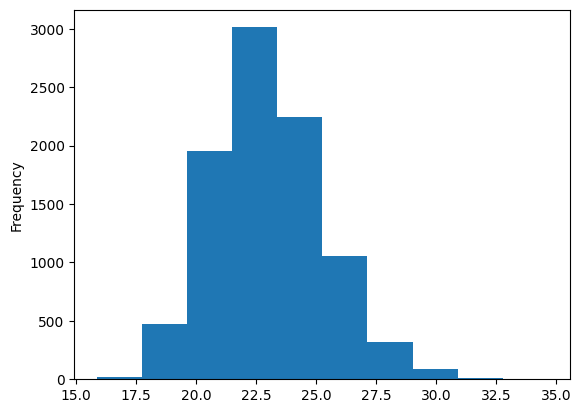

In [9]:
avg_day_visit['avg_day_visit'].plot(kind = 'hist', bins = 10)

In [10]:
ft

,payment_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,customer_key
0,P026,T049189,I00177,S00307,1,ct,35.0,35.0,C004510
1,P022,T041209,I00248,S00595,1,rolls,26.0,26.0,C008967
2,P030,T03633,I00195,S00496,8,ct,12.5,100.0,C007261
3,P032,T084631,I00131,S0086,8,ct,14.0,112.0,C007048
4,P014,T071276,I00050,S00488,8,cans,8.0,64.0,C006430
...,...,...,...,...,...,...,...,...,...
999995,P010,T09247,I00063,S00502,5,cans,40.0,200.0,C003726
999996,P021,T023483,I00252,S00225,1,ct,11.0,11.0,C002581
999997,P035,T039372,I00119,S00555,7,ct,53.0,371.0,C006133
999998,P031,T097975,I00257,S00440,2,ct,21.0,42.0,C008735


## Stores?

In [11]:
sd = pd.read_csv('data/store_dim.csv')
sd.head()

,store_key,division,district,upazila
0,S0001,SYLHET,HABIGANJ,AJMIRIGANJ
1,S0002,SYLHET,HABIGANJ,BAHUBAL
2,S0003,SYLHET,HABIGANJ,BANIACHONG
3,S0004,SYLHET,HABIGANJ,CHUNARUGHAT
4,S0005,SYLHET,HABIGANJ,HABIGANJ SADAR


In [12]:
store_month = ft.merge(sd, on= 'store_key').merge(td, on = 'time_key')[['division', 'total_price', 'month', 'year']]
total_per_store = store_month.groupby(['month', 'year','division']).sum().reset_index()
total_per_store

,month,year,division,total_price
0,1,2014,BARISAL,35031.50
1,1,2014,CHITTAGONG,94926.00
2,1,2014,DHAKA,192214.25
3,1,2014,KHULNA,54601.00
4,1,2014,RAJSHAHI,55584.50
...,...,...,...,...
590,12,2020,DHAKA,522712.50
591,12,2020,KHULNA,139906.25
592,12,2020,RAJSHAHI,156888.25
593,12,2020,RANGPUR,110664.50


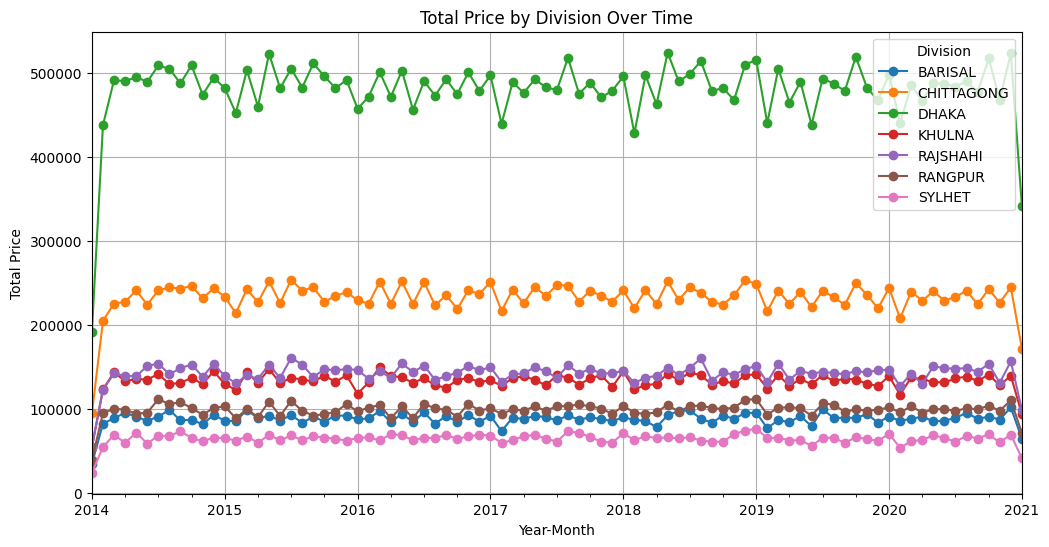

In [13]:
total_per_store['date'] = pd.to_datetime(total_per_store[['year', 'month']].assign(day=1))

pivot_total_per_store = total_per_store.pivot_table(index='date', columns='division', values='total_price', aggfunc='sum')

pivot_total_per_store.plot(figsize=(12, 6), marker='o')
plt.title('Total Price by Division Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Price')
plt.legend(title='Division')
plt.grid(True)
plt.show()

In [14]:
itd = pd.read_csv('data/item_dim.csv')
itd[['item_key', 'item_name', 'desc', 'unit_price']]

,item_key,item_name,desc,unit_price
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75
...,...,...,...,...
259,I00260,Napkins Square Lunch,Kitchen Supplies,15.00
260,I00261,POM 2 ply paper towels,Kitchen Supplies,33.00
261,I00262,Strong Everyday Napkins,Kitchen Supplies,14.00
262,I00263,Advil 2 pill packets,Medicine,14.00


## Try to make a Recommendation System (WE got to make a better one I guess, this doesn't include history of the customer)

https://towardsdatascience.com/recommender-systems-matrix-factorization-using-pytorch-bd52f46aa199 

In [15]:
ft.head()

,payment_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,customer_key
0,P026,T049189,I00177,S00307,1,ct,35.0,35.0,C004510
1,P022,T041209,I00248,S00595,1,rolls,26.0,26.0,C008967
2,P030,T03633,I00195,S00496,8,ct,12.5,100.0,C007261
3,P032,T084631,I00131,S0086,8,ct,14.0,112.0,C007048
4,P014,T071276,I00050,S00488,8,cans,8.0,64.0,C006430


In [16]:
itd.head()

,item_key,item_name,desc,unit_price,man_country,supplier,unit
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50,Netherlands,Bolsius Boxmeer,cans
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75,poland,CHROMADURLIN S.A.S,cans
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75,Bangladesh,DENIMACH LTD,cans
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75,Netherlands,Bolsius Boxmeer,cans
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75,Finland,HARDFORD AB,cans


### Standardize by category probably??? Buying packs and singular values could be messing with the recommendation

In [17]:
favorite_products = ft.groupby('item_key')[['quantity','total_price']].sum().sort_values('quantity', ascending = False)
favorite_products['rating'] = stats.zscore( favorite_products['quantity']) + 2.5003113682852245
favorite_products.head()

,quantity,total_price,rating
item_key,,,
I00015,23969,161790.75,5.370828
I00203,23958,431244.00,5.345385
I00230,23852,357780.00,5.100205
I00023,23802,160663.50,4.984554
I00061,23740,1305700.00,4.841147


In [18]:
ft_utility_matrix = ft[['item_key', 'customer_key', 'quantity']].pivot_table(values = 'quantity', index = 'customer_key', columns = 'item_key', fill_value = 0)
ft_utility_matrix.head()

item_key,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,...,I00255,I00256,I00257,I00258,I00259,I00260,I00261,I00262,I00263,I00264
customer_key,,,,,,,,,,,,,,,,,,,,,
C000001,0.0,5.0,6.5,0.0,8.0,0.0,0.0,0.0,11.0,10.0,...,10.0,2.5,5.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8.0
C000002,4.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.000000,3.000000,11.0
C000003,0.0,6.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,10.0,1.0,0.000000,5.666667,0.0
C000004,3.0,7.0,0.0,6.0,0.0,0.0,0.0,6.5,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,9.0,0.0,5.333333,0.000000,0.0
C000005,11.0,7.0,0.0,7.0,0.0,4.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,9.0,0.0,0.0,7.000000,7.000000,5.0


In [19]:
import sklearn
from sklearn.decomposition import TruncatedSVD

In [20]:
X = ft_utility_matrix.T
X.head()

customer_key,C000001,C000002,C000003,C000004,C000005,C000006,C000007,C000008,C000009,C000010,...,C009182,C009183,C009184,C009185,C009186,C009187,C009188,C009189,C009190,C009191
item_key,,,,,,,,,,,,,,,,,,,,,
I00001,0.0,4.0,0.0,3.0,11.0,0.0,9.0,0.0,0.0,6.0,...,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,2.5,0.0
I00002,5.0,0.0,6.0,7.0,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,5.0,4.0,10.0,0.0,9.0,4.0,0.0,0.0,11.0
I00003,6.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,...,0.0,5.0,8.0,0.0,8.0,11.0,6.0,0.0,7.5,0.0
I00004,0.0,8.0,0.0,6.0,7.0,0.0,0.0,0.0,4.0,0.0,...,7.0,1.0,0.0,0.0,9.0,0.0,7.0,6.0,6.0,0.0
I00005,8.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X.shape

(264, 9191)

In [22]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(264, 10)

In [23]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape
correlation_matrix

array([[1.        , 0.83673477, 0.90535211, ..., 0.90003522, 0.90721932,
        0.80818079],
       [0.83673477, 1.        , 0.91004059, ..., 0.84010171, 0.88999893,
        0.89501887],
       [0.90535211, 0.91004059, 1.        , ..., 0.94197808, 0.93031072,
        0.79384299],
       ...,
       [0.90003522, 0.84010171, 0.94197808, ..., 1.        , 0.93545618,
        0.77583302],
       [0.90721932, 0.88999893, 0.93031072, ..., 0.93545618, 1.        ,
        0.9038944 ],
       [0.80818079, 0.89501887, 0.79384299, ..., 0.77583302, 0.9038944 ,
        1.        ]])

In [24]:
i = 'I00010'
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

9

In [25]:
correlation_product_ID = correlation_matrix[product_ID]

In [26]:
Recommend = list(X.index[correlation_product_ID > 0.95])
Recommend.remove(i) 
Recommend[0:9]

['I00003',
 'I00013',
 'I00027',
 'I00031',
 'I00036',
 'I00051',
 'I00054',
 'I00056',
 'I00057']

In [27]:
itd.iloc[1]

item_key                                I00002
item_name      A&W Root Beer Diet - 12 oz cans
desc                        a. Beverage - Soda
unit_price                                6.75
man_country                             poland
supplier                    CHROMADURLIN S.A.S
unit                                      cans
Name: 1, dtype: object

## EMBEDDINGS NOW

In [28]:
#! pip install gensim

In [29]:
itd

,item_key,item_name,desc,unit_price,man_country,supplier,unit
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50,Netherlands,Bolsius Boxmeer,cans
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75,poland,CHROMADURLIN S.A.S,cans
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75,Bangladesh,DENIMACH LTD,cans
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75,Netherlands,Bolsius Boxmeer,cans
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75,Finland,HARDFORD AB,cans
...,...,...,...,...,...,...,...
259,I00260,Napkins Square Lunch,Kitchen Supplies,15.00,Cambodia,NINGBO SEDUNO IMP & EXP CO.LTD,ct
260,I00261,POM 2 ply paper towels,Kitchen Supplies,33.00,Lithuania,BIGSO AB,ct
261,I00262,Strong Everyday Napkins,Kitchen Supplies,14.00,Netherlands,Bolsius Boxmeer,ct
262,I00263,Advil 2 pill packets,Medicine,14.00,Lithuania,BIGSO AB,Ct


In [30]:
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [31]:
rec_df = ft.merge(itd, left_on='item_key', right_on='item_key')[['item_key', 'customer_key', 'item_name', 'quantity']]
rec_df.head()

,item_key,customer_key,item_name,quantity
0,I00177,C004510,M&M Peanut Candy 1.7 oz,1
1,I00177,C008383,M&M Peanut Candy 1.7 oz,1
2,I00177,C006666,M&M Peanut Candy 1.7 oz,10
3,I00177,C004584,M&M Peanut Candy 1.7 oz,2
4,I00177,C004336,M&M Peanut Candy 1.7 oz,10


In [32]:
customers = rec_df["customer_key"].unique().tolist()
len(customers)

9191

#### Data Preparation (I need to make it so it takes into accout how many was bought)

In [33]:
# shuffle customer ID's
random.shuffle(customers)

customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = rec_df[rec_df['customer_key'].isin(customers_train)]
validation_df = rec_df[~rec_df['customer_key'].isin(customers_train)]

In [35]:
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["customer_key"] == i][['item_name', 'quantity']].set_index('item_name').to_dict()['quantity']
    item_lst = []
    for item, quantity in temp.items():
        item_lst.extend([item] * quantity)
    purchases_train.append(item_lst)

100%|██████████| 8272/8272 [06:34<00:00, 20.99it/s]


In [36]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['customer_key'].unique()):
    temp = validation_df[validation_df["customer_key"] == i][['item_name', 'quantity']].set_index('item_name').to_dict()['quantity']
    item_lst = []
    for item, quantity in temp.items():
            item_lst.extend([item] * quantity)
    purchases_val.append(item_lst)

100%|██████████| 919/919 [00:04<00:00, 214.52it/s]


In [37]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(33746363, 43972920)

In [38]:
model.save("word2vec_2.model")

In [39]:
model.init_sims(replace=True)

In [40]:
print(model)

Word2Vec<vocab=259, vector_size=100, alpha=0.03>


In [41]:
X = model.wv[model.wv.index_to_key]

# Check the shape of the extracted vectors
X.shape

(259, 100)

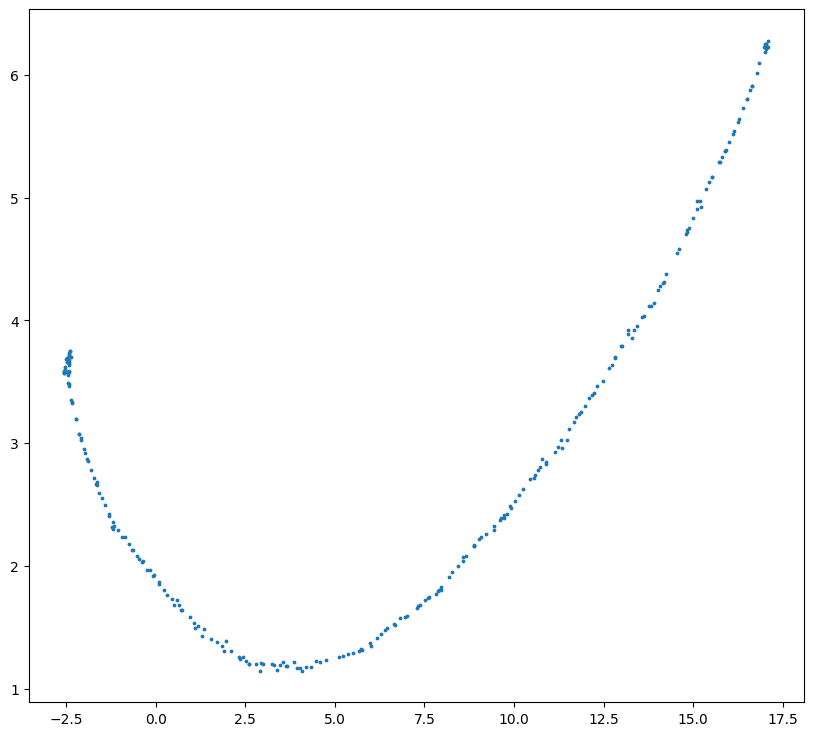

In [66]:
#collapse
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=4, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

In [48]:
products = train_df[["item_key", "item_name"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='item_name', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('item_name')['item_key'].apply(list).to_dict()

In [49]:
products_dict

{'100% Juice Box Variety 6.75 oz ': ['I00082'],
 'A&W Root Beer - 12 oz cans': ['I00001'],
 'A&W Root Beer Diet - 12 oz cans': ['I00002'],
 'Advil 2 pill packets': ['I00263'],
 'All Purpose Cleaner 409 Spray': ['I00244'],
 'Altoids Small Packs Variety': ['I00236'],
 'Apple Sauce Variety GoGO Squeeze 3.2oz': ['I00185'],
 'AquaFina Purified Drinking Water 16oz': ['I00089'],
 'Austin Cookie Cracker Variety': ['I00220'],
 'Austin Toasty Crackers w/ PBtr': ['I00221'],
 'Baked Chips Variety Mix Frito': ['I00150'],
 "Barq's Root Beer - 12 oz cans": ['I00003'],
 'Belvita Hard Biscuits Blueberry': ['I00186'],
 'Belvita Hard Biscuits Cinnamon': ['I00187'],
 'Belvita Protein Oats Soft Biscuit': ['I00188'],
 'Blue Diamond Almonds Rstd, Sltd': ['I00218'],
 'Bounty Paper Towels Select a Size ': ['I00245'],
 'Breath Savers Peppermints 12/roll ': ['I00237'],
 'Brisk Lemon Iced Tea - 12 oz cans': ['I00075'],
 'Cascade Gel Packs Dishwasher': ['I00246'],
 'Cascade Gel w/ Dawn Dishwasher': ['I00247'],
 'C

In [57]:
def similar_products(v, n=6):
    ms = model.wv.similar_by_vector(v, topn=n+1)[1:]
    
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0],j[0], j[1])
        new_ms.append(pair)
        
    return new_ms   

# Test the function with the vector for 'I00177'
similar_products(model.wv['M&M Peanut Candy 1.7 oz'])


[('I00248', 'Charmin Ultra Bath Tissue', 0.8770682215690613),
 ('I00131', 'Paper Bowls 20 oz Ultra Strong', 0.8620390295982361),
 ('I00195', 'Dole Fruit in Gel Cups 4.3 oz', 0.8559912443161011),
 ('I00050', 'Waterloo Sparkling Watermelon 12oz', 0.8250974416732788),
 ('I00058', 'Premier Protein Shake Choc. 11oz', 0.8107554912567139),
 ('I00075', 'Brisk Lemon Iced Tea - 12 oz cans', 0.7917360067367554)]

In [59]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [60]:
len(purchases_val[0])

432

In [61]:
aggregate_vectors(purchases_val[0])

array([ 0.05941966, -0.04661133,  0.07398722, -0.15370075,  0.02059752,
       -0.00120485,  0.03793414, -0.0218762 , -0.10665628,  0.02802796,
       -0.1311308 , -0.00282951, -0.00932602, -0.00298587,  0.0669056 ,
       -0.07430886,  0.03823744,  0.05652745, -0.04210201, -0.02234498,
        0.03397657,  0.05929225,  0.04307674, -0.01089976, -0.03347413,
        0.03739505,  0.05654528,  0.06377043,  0.05973585,  0.04521465,
       -0.05510211, -0.05257014,  0.00744126,  0.06481232, -0.01475078,
        0.00264072,  0.12935482, -0.02084906,  0.08405214, -0.00086541,
        0.05006506, -0.00785779,  0.13668582, -0.09141341, -0.05247477,
        0.02975421,  0.01705895,  0.0035869 , -0.08512492,  0.07088518,
       -0.00119888, -0.02292171,  0.0724631 ,  0.03990624, -0.02618906,
       -0.01111947,  0.10624427,  0.10516812, -0.08040443,  0.08497981,
        0.03375259, -0.00827238,  0.02078515, -0.00223477, -0.09484815,
        0.0210279 , -0.05342191,  0.04284326, -0.09126592, -0.02

In [62]:
customers_train[0]

'C003361'

In [63]:
rec_df[rec_df['customer_key'] == 'C002656'].groupby('item_name')['quantity'].sum()

item_name
100% Juice Box Variety 6.75 oz        1
Austin Toasty Crackers w/ PBtr        5
Baked Chips Variety Mix Frito         6
Barq's Root Beer - 12 oz cans         6
Belvita Protein Oats Soft Biscuit     4
                                     ..
V8 100% Vegetable Juice 11oz cans    14
Vita Coconut Water 10oz              10
Waterloo Sparkling Mango 12oz         3
Waterloo Sparkling Original 12oz      2
Wonderful Pistachios (in shell)       8
Name: quantity, Length: 85, dtype: int64

In [68]:
aggregate_vectors(purchases_train[0])

array([ 4.87102084e-02, -3.37685160e-02,  8.76784474e-02, -1.61455870e-01,
        1.49674732e-02, -4.02827282e-03,  4.62708212e-02, -2.67039146e-02,
       -1.17439456e-01,  5.33536747e-02, -1.33446798e-01,  3.99110047e-03,
       -1.52002973e-02, -8.09520669e-03,  7.38252401e-02, -7.17619285e-02,
        2.68237069e-02,  5.26300631e-02, -4.80514839e-02, -1.46373631e-02,
        2.12579127e-02,  6.95805624e-02,  4.27926220e-02, -2.09792444e-04,
       -5.32155111e-02,  3.32325026e-02,  5.05976602e-02,  2.87884474e-02,
        5.52647710e-02,  4.94486652e-02, -6.07686974e-02, -5.23375496e-02,
       -1.47662284e-02,  6.03189357e-02, -2.11489070e-02,  2.47777021e-03,
        1.23908401e-01, -1.21632218e-02,  8.50438029e-02,  5.63222030e-03,
        5.47095314e-02, -9.68141016e-03,  1.35399491e-01, -8.75521898e-02,
       -5.61403185e-02,  3.73707749e-02,  5.42613678e-04, -3.21489945e-03,
       -7.41549805e-02,  8.75242576e-02,  1.82934720e-02, -1.96094178e-02,
        8.36759806e-02,  

In [64]:
similar_products(aggregate_vectors(purchases_val[0]))

[('I00161', 'Frito Fiesta Flavors Variety', 0.6520535945892334),
 ('I00253', 'ForceFlex Trash Bags 13 Gal ', 0.6494479179382324),
 ('I00095', 'Propel Zero Variety 20 oz', 0.6448408365249634),
 ('I00043', 'Topo Chico 20oz plastic', 0.6439722180366516),
 ('I00134', 'Red Plastic Cups 18oz', 0.643570065498352),
 ('I00102', "Half & Half -Land o Lakes Mini Moo's", 0.6429911255836487)]

In [70]:
aggregate_vectors(purchases_val[0])

array([ 0.05941966, -0.04661133,  0.07398722, -0.15370075,  0.02059752,
       -0.00120485,  0.03793414, -0.0218762 , -0.10665628,  0.02802796,
       -0.1311308 , -0.00282951, -0.00932602, -0.00298587,  0.0669056 ,
       -0.07430886,  0.03823744,  0.05652745, -0.04210201, -0.02234498,
        0.03397657,  0.05929225,  0.04307674, -0.01089976, -0.03347413,
        0.03739505,  0.05654528,  0.06377043,  0.05973585,  0.04521465,
       -0.05510211, -0.05257014,  0.00744126,  0.06481232, -0.01475078,
        0.00264072,  0.12935482, -0.02084906,  0.08405214, -0.00086541,
        0.05006506, -0.00785779,  0.13668582, -0.09141341, -0.05247477,
        0.02975421,  0.01705895,  0.0035869 , -0.08512492,  0.07088518,
       -0.00119888, -0.02292171,  0.0724631 ,  0.03990624, -0.02618906,
       -0.01111947,  0.10624427,  0.10516812, -0.08040443,  0.08497981,
        0.03375259, -0.00827238,  0.02078515, -0.00223477, -0.09484815,
        0.0210279 , -0.05342191,  0.04284326, -0.09126592, -0.02